### Fit Gaussians to $\psi^r$, first row by row, then column by column

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hf
from scipy import optimize
from astropy.io import fits

# Load the saved arrays from .npz file with hf.import_npz
rundir = 'xsig20.0_ysig0.14_w30'
niter = 30
hf.load_npz(rundir+f'/phi_psi_n{niter}.npz', globals())
# limits
xmin,xmax,ymin,ymax = 0,650,-23,-13

"""
# write FITS file - note 'xy' indexing for psi_r
hdu = fits.PrimaryHDU(data=np.flip(psi_r,0))
hdu.writeto(rundir+f'/psi_n{niter}.fits',overwrite=True)
"""

""" Gaussian function to fit \psi """
def gaussian(x, p1, p2, p3):
    return p1 * np.exp(-0.5 * ((x - p2)/p3)**2)

# fit a Gaussian to each row (constant abs magnitude)
psi_fit = psi_r * 0 
par_fit = np.zeros([len(y_n),3])
for iy in range(len(y_n)):
    xdata = x_n
    ydata = psi_r[iy,:]
    imax = np.argmax(ydata)
    popt, _ = optimize.curve_fit(gaussian, xdata, ydata, 
                                 p0=[ydata[imax],xdata[imax],25], 
                                 bounds=([0,xmin,0],[np.inf,xmax,np.inf]))
    psi_fit[iy,:] = gaussian(xdata, *popt)
    par_fit[iy,:] = popt

# fit a Gaussian to each column (constant velocity width)
psi_fit2 = psi_r * 0 
par_fit2 = np.zeros([len(x_n),3])
for ix in range(len(x_n)):
    xdata = y_n
    ydata = psi_r[:,ix]
    imax = np.argmax(ydata)
    popt, _ = optimize.curve_fit(gaussian, xdata, ydata, 
                                 p0=[ydata[imax],xdata[imax],0.4],
                                 bounds=([0,ymin,0],[np.inf,ymax,np.inf]))
    psi_fit2[:,ix] = gaussian(xdata, *popt)
    par_fit2[ix,:] = popt

### Make a six-panel summary plot showing $\phi$ and $\psi$, along with the best-fit powerlaws of the ridge

Here we use simple manual rejection method and `optimize.curve_fit` to accomplish quick result.

[-19.76562063   4.38664955] [0.03981439 0.05967725]
[-19.77521063   3.78285285] [0.01443807 0.02681638]


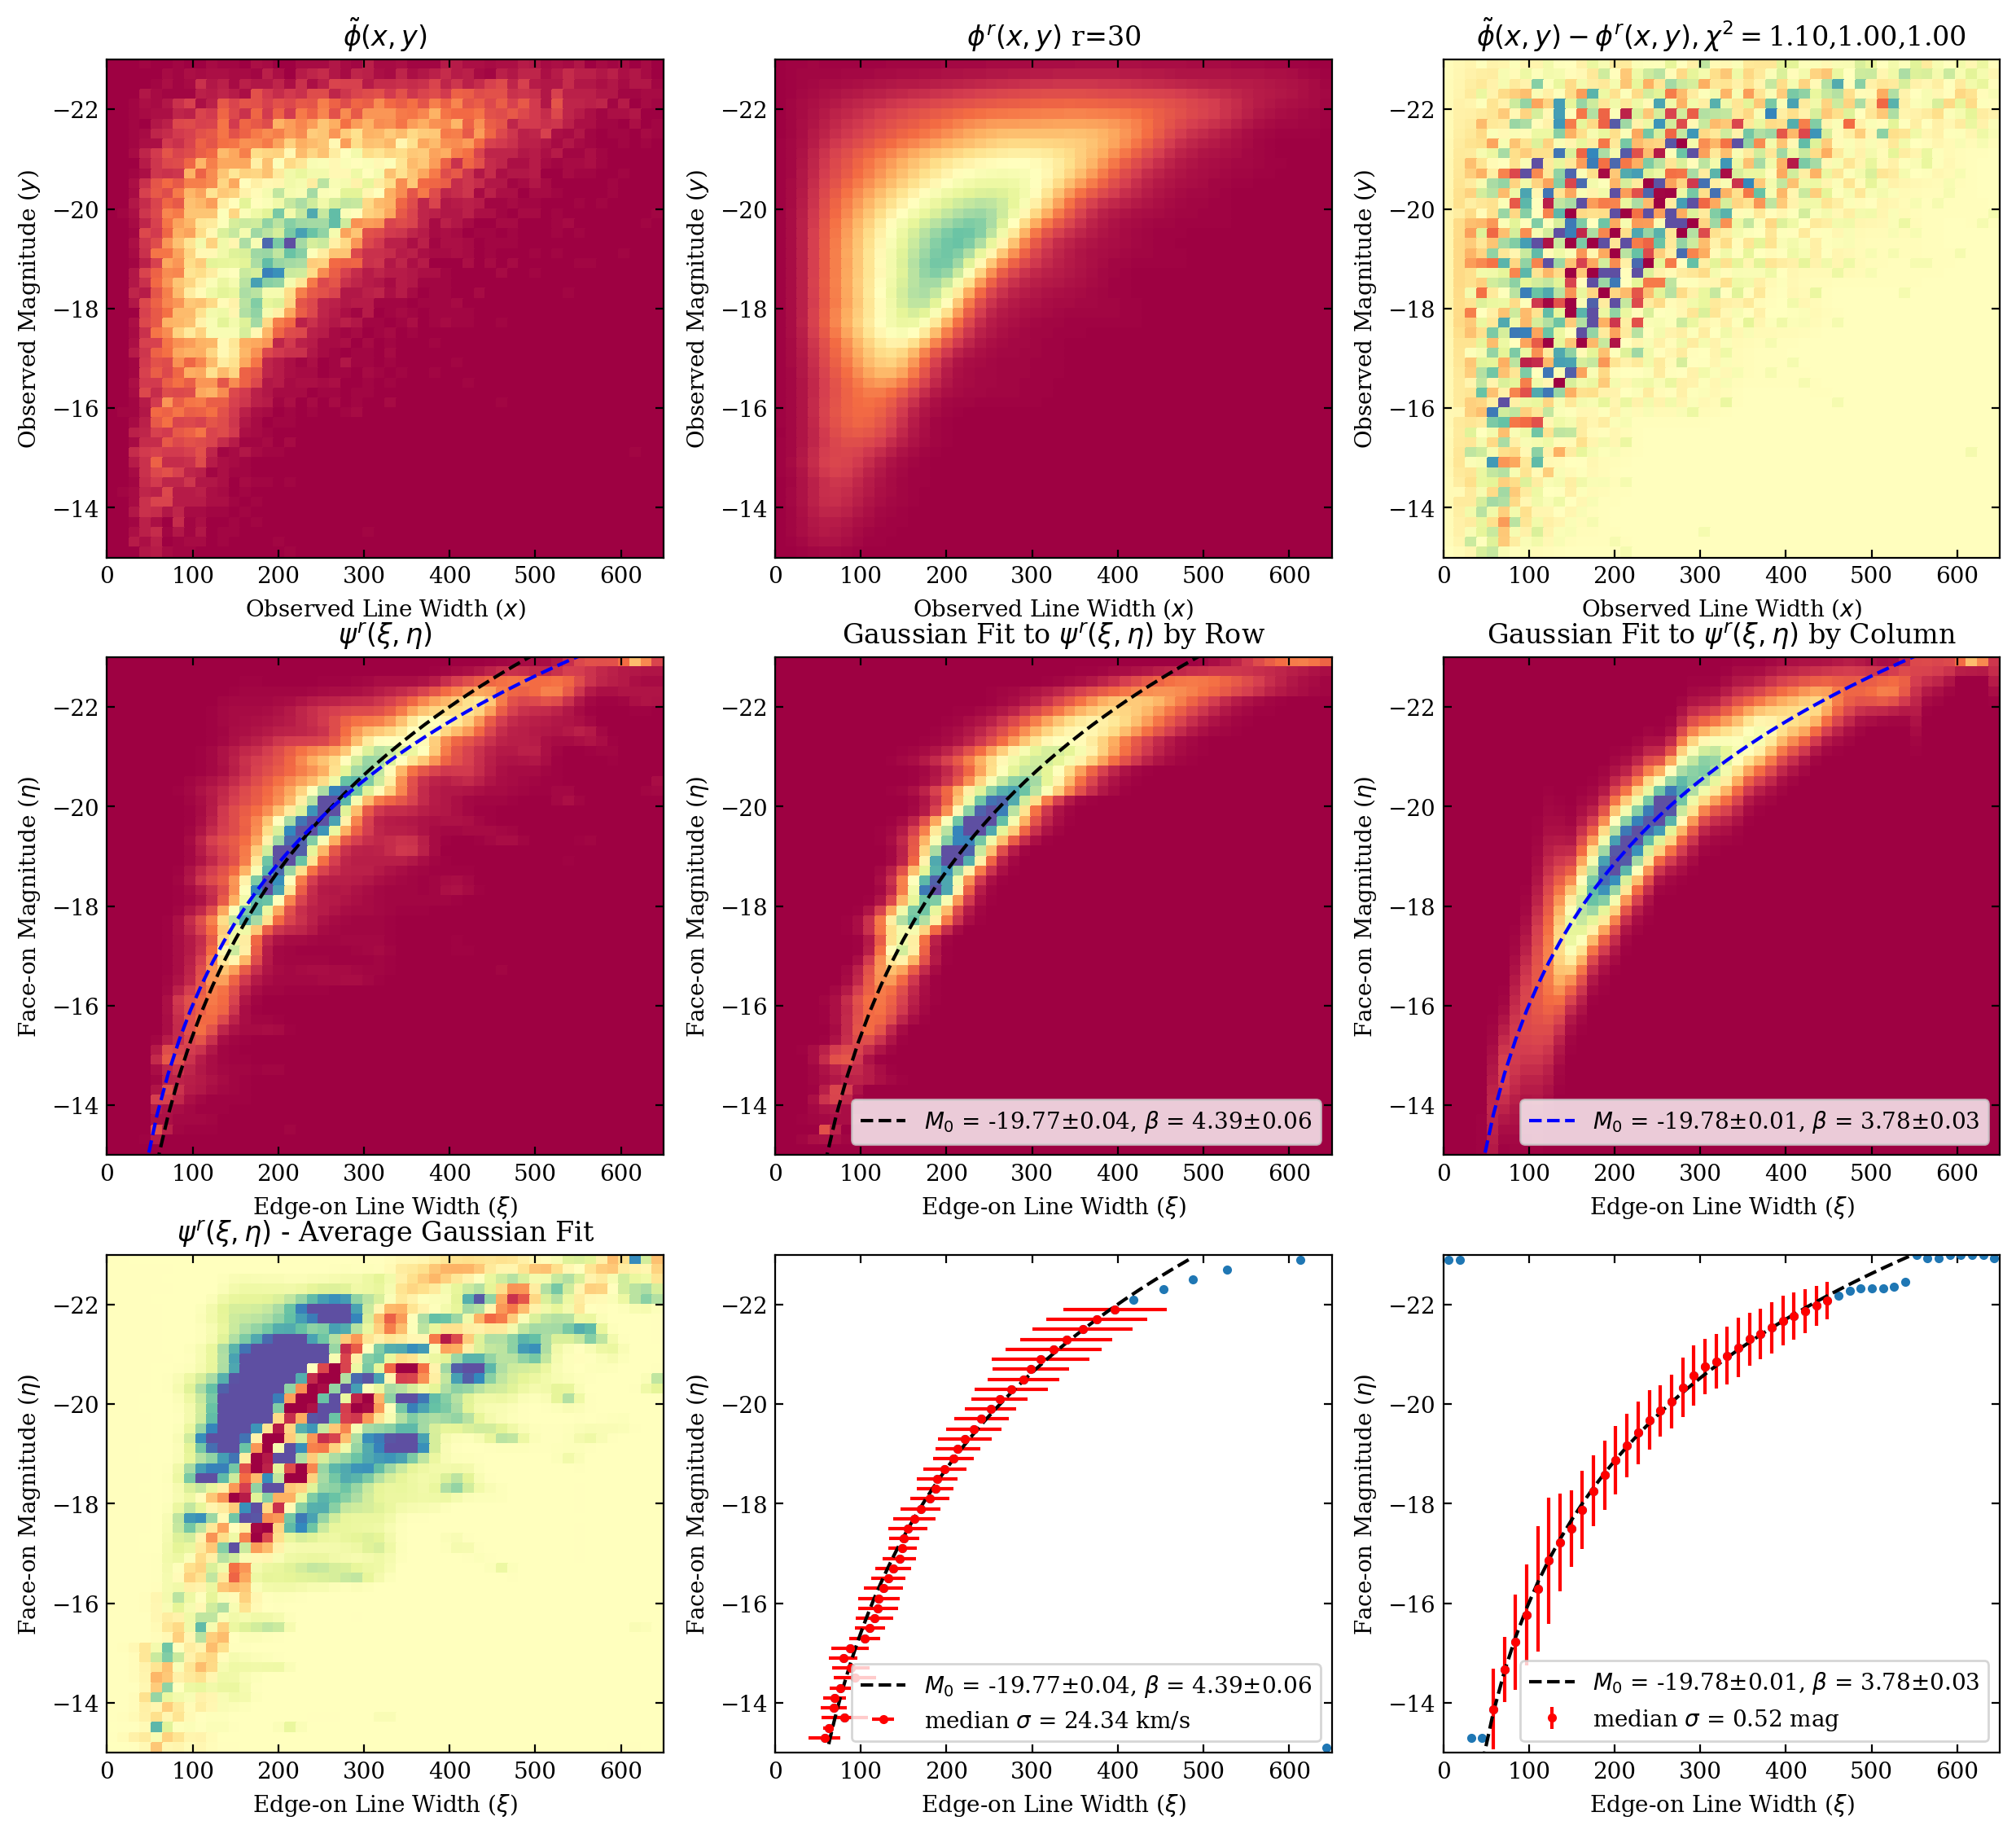

In [2]:
""" powerlaw functions to fit the ridge """
""" p1: abs mag at which W = 250 km/s """
""" p2: power law slope beta - L ~ W^beta """
def absmag(x, p1, p2):
    # when x is log(W) in km/s
    return p1 - 2.5 * p2 * (x - np.log10(250.))

def logW(x, p1, p2):
    # when x is absolute magitude
    return np.log10(250.) - (x - p1)/(2.5 * p2)

# set up plotting grid
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,9*1.5))

# set uniform contrast
x0,x1,y0,y1 = xmin,xmax,ymax,ymin
vmin,vmax = 0, phi_n.max()

X,Y = np.meshgrid(x_n,y_n)
ax[0,0].pcolormesh(X, Y, phi_n, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax)
ax[0,0].set_xlabel(xlabel)
ax[0,0].set_ylabel(ylabel)
ax[0,0].set_title('$\\tilde{\phi}(x,y)$')
ax[0,0].set_xlim(xmin,xmax)
ax[0,0].set_ylim(ymax,ymin)

ax[0,1].pcolormesh(X, Y, phi_r, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax)
ax[0,1].set_xlabel(xlabel)
ax[0,1].set_ylabel(ylabel)
ax[0,1].set_title('$\phi^r(x,y)$'+f' r={niter}')
ax[0,1].set_xlim(xmin,xmax)
ax[0,1].set_ylim(ymax,ymin)

ax[0,2].pcolormesh(X,Y,phi_n-phi_r,cmap='Spectral', edgecolors='face', vmin=-vmax/10,vmax=vmax/10)
ax[0,2].set_xlabel(xlabel)
ax[0,2].set_ylabel(ylabel)
ax[0,2].set_title('$\\tilde{\phi}(x,y) - \phi^r(x,y), \chi^2 =$'+f'{chisq0[-1]:.2f},{chisq1[-1]:.2f},{chisq2[-1]:.2f}') 
ax[0,2].set_xlim(xmin,xmax)
ax[0,2].set_ylim(ymax,ymin)

ax[2,1].plot(par_fit[:,1],eta_n,'.')
ax[2,1].set_xlabel(xilabel)
ax[2,1].set_ylabel(etalabel)
ax[2,1].set_ylim(y0,y1)
ax[2,1].set_xlim(x0,x1)
#ax[2,1].set_xscale('log')
xdata = eta_n[5:49] # absolute magntude
ydata = np.log10(par_fit[5:49,1]) # log W/km/s
ysigm = par_fit[5:49,2]/par_fit[5:49,1]/np.log(10)
popt, pcov = optimize.curve_fit(logW, xdata, ydata, sigma=ysigm, p0=[-20,4.0])
perr = np.sqrt(np.diag(pcov))
ax[2,1].errorbar(10.**ydata, xdata, xerr = par_fit[5:49,2], fmt='r.', 
                 label=f'median $\sigma$ = {np.median(par_fit[:,2]):.2f} km/s')
ax[2,1].plot(10.**logW(eta_n, *popt), eta_n,'k--',
    label=f'$M_0$ = {popt[0]:.2f}$\pm${perr[0]:.2f}, $\\beta$ = {popt[1]:.2f}$\pm${perr[1]:.2f}')
ax[2,1].legend()
print(popt,perr)

ax[2,2].plot(xi_n,par_fit2[:,1],'.')
ax[2,2].set_xlabel(xilabel)
ax[2,2].set_ylabel(etalabel)
ax[2,2].set_xlim(x0,x1)
ax[2,2].set_ylim(y0,y1)
#ax[2,2].set_xscale('log')
xdata = np.log10(xi_n[4:35]) # log W/km/s
ydata = par_fit2[4:35,1] # abs magnitude from gaussian fit
ysigm = par_fit2[4:35,2] # gaussian fit dispersion
popt2, pcov2 = optimize.curve_fit(absmag, xdata, ydata, sigma=ysigm, p0=[-20,4.0])
perr2 = np.sqrt(np.diag(pcov2))
ax[2,2].errorbar(10**xdata, ydata, yerr=ysigm, fmt='r.',
                 label=f'median $\sigma$ = {np.median(par_fit2[:,2]):.2f} mag')
ax[2,2].plot(xi_n, absmag(np.log10(xi_n), *popt2),'k--',
    label=f'$M_0$ = {popt2[0]:.2f}$\pm${perr2[0]:.2f}, $\\beta$ = {popt2[1]:.2f}$\pm${perr2[1]:.2f}')
ax[2,2].legend()
print(popt2,perr2)

XI,ETA = np.meshgrid(xi_n,eta_n)
cb = ax[1,0].pcolormesh(XI, ETA, psi_r, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax*1.5) 
ax[1,0].set_xlabel(xilabel)
ax[1,0].set_ylabel(etalabel)
ax[1,0].set_title('$\psi^r(\\xi,\eta)$')
ax[1,0].set_xlim(xmin,xmax)
ax[1,0].set_ylim(ymax,ymin)
ax[1,0].plot(xi_n, absmag(np.log10(xi_n), *popt),'k--',
    label=f'$M_0$ = {popt[0]:.2f}$\pm${perr[0]:.2f}, $\\beta$ = {popt[1]:.2f}$\pm${perr[1]:.2f}')
ax[1,0].plot(xi_n, absmag(np.log10(xi_n), *popt2),'b--',
    label=f'$M_0$ = {popt2[0]:.2f}$\pm${perr2[0]:.2f}, $\\beta$ = {popt2[1]:.2f}$\pm${perr2[1]:.2f}')
#ax[1,0].legend()

ax[1,1].pcolormesh(XI, ETA, psi_fit, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax*1.5) 
ax[1,1].set_xlabel(xilabel)
ax[1,1].set_ylabel(etalabel)
ax[1,1].set_title('Gaussian Fit to $\psi^r(\\xi,\eta)$ by Row')
ax[1,1].set_xlim(xmin,xmax)
ax[1,1].set_ylim(ymax,ymin)
ax[1,1].plot(xi_n, absmag(np.log10(xi_n), *popt),'k--',
    label=f'$M_0$ = {popt[0]:.2f}$\pm${perr[0]:.2f}, $\\beta$ = {popt[1]:.2f}$\pm${perr[1]:.2f}')
ax[1,1].legend()

ax[1,2].pcolormesh(XI,ETA,psi_fit2,cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax*1.5)
ax[1,2].set_xlabel(xilabel)
ax[1,2].set_ylabel(etalabel)
ax[1,2].set_title('Gaussian Fit to ${\psi^r}(\\xi,\eta)$ by Column')
ax[1,2].set_xlim(xmin,xmax)
ax[1,2].set_ylim(ymax,ymin)
ax[1,2].plot(xi_n, absmag(np.log10(xi_n), *popt2),'b--',
    label=f'$M_0$ = {popt2[0]:.2f}$\pm${perr2[0]:.2f}, $\\beta$ = {popt2[1]:.2f}$\pm${perr2[1]:.2f}')
ax[1,2].legend()

ax[2,0].pcolormesh(XI,ETA,psi_r-(psi_fit+psi_fit2)/2,cmap='Spectral', edgecolors='face', vmin=-vmax/10, vmax=vmax/10)
ax[2,0].set_xlabel(xilabel)
ax[2,0].set_ylabel(etalabel)
ax[2,0].set_title('${\psi^r}(\\xi,\eta)$ - Average Gaussian Fit')
ax[2,0].set_xlim(xmin,xmax)
ax[2,0].set_ylim(ymax,ymin)

# save plot as png file
plt.savefig(rundir+f'/n{niter}.png', bbox_inches='tight');